In [1]:
# Import necessary libraries
from prophet import Prophet
from pyhive import presto as presto_con
from sklearn.metrics import mean_absolute_percentage_error

import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

# Set seaborn style to "ticks"
sns.set_style("ticks")

# Ignore warnings to improve code readability
warnings.filterwarnings('ignore')

# Set option to display all columns in Pandas DataFrames
pd.set_option('display.max_columns', None)

In [2]:
class PrestoConnector:
    def __init__(self):
        # Load Presto connection parameters from a JSON file
        presto_parameters = json.load(open("auth/auth.json"))['presto_connector']
        print(presto_parameters)  # Print parameters for verification
        self.create_db_cursor(presto_parameters)  # Create a database cursor

    def create_db_cursor(self, parameters):
        # Create a connection to Presto using provided parameters
        conn = presto_con.connect(**parameters)
        self.cursor = conn.cursor()  # Set the cursor for executing queries

    def execute_db_query(self, query):
        # Execute the provided query using the cursor
        self.cursor.execute(query)
        # Fetch the query result and convert it to a Pandas DataFrame
        result = pd.DataFrame(self.cursor.fetchall(), columns=[i[0] for i in self.cursor.description])
        return result

    def get_table_shape(self, table):
        # Fetch the number of rows in the table
        rows_query = f"SELECT COUNT(*) AS rows FROM {table}"
        rows = self.execute_db_query(rows_query)['rows'][0]

        # Fetch a single row to determine the number of columns
        cols_query = f"SELECT * FROM {table} LIMIT 1"
        cols = len(self.execute_db_query(cols_query).T)

        return rows, cols  # Return the shape (rows, columns) of the query result


In [3]:
# Create an instance of the PrestoConnector class
presto = PrestoConnector()

{'host': 'ec2-54-196-119-55.compute-1.amazonaws.com', 'port': 8889, 'username': 'hadoop', 'catalog': 'hive', 'schema': 'project_schema_001'}


In [4]:
# testing connection with a sample query
sql = "select * from renewable_power_plants_de limit 20"
df = presto.execute_db_query(sql)
df.head()

,electrical_capacity,energy_source_level_1,energy_source_level_2,energy_source_level_3,technology,data_source,nuts_1_region,nuts_2_region,nuts_3_region,lon,lat,municipality,municipality_code,postcode,address,federal_state,commissioning_date,decommissioning_date,voltage_level,eeg_id,dso,dso_id,tso
0,0.02990,Renewable energy,Solar,None,Photovoltaics,Amprion,DEB,DEB3,DEB3F,7.520281,49.485492,Niedermohr,7335030,66879.0,None,Rheinland-Pfalz,2011-12-16,None,low voltage,None,Stadtwerke Ramstein-Miesenbach GmbH,10000886.0,Amprion
1,0.00588,Renewable energy,Solar,None,Photovoltaics,TenneT,DE7,DE72,DE723,8.290839,50.433058,None,6533019,35796.0,None,Hamburg,2010-04-01,None,low voltage,None,EAM Netz GmbH,10003990.0,TenneT
2,0.00264,Renewable energy,Solar,None,Photovoltaics,TransnetBW,DE1,DE13,DE134,8.032053,48.290476,None,8317129,77790.0,None,Baden-Württemberg,2008-12-15,None,low voltage,None,Überlandwerk Mittelbaden GmbH & Co. KG,10001904.0,TransnetBW
3,0.04368,Renewable energy,Solar,None,Photovoltaics,TenneT,DE9,DE91,DE91C,9.751720,51.479569,Niemetal,3159024,37127.0,None,Niedersachsen,2011-12-16,None,low voltage,None,EAM Netz GmbH,10003990.0,TenneT
4,0.00387,Renewable energy,Solar,None,Photovoltaics,Amprion,DEA,DEA5,DEA58,7.834675,51.447159,Menden,5962040,58708.0,None,Nordrhein-Westfalen,2011-12-16,None,low voltage,None,Stadtwerke Menden GmbH,10000994.0,Amprion


In [5]:
def plot_df_timeseries(df, labels, title_):
    """
    Plots a time series for each column in the DataFrame, excluding the 'day' column.

    Parameters:
    - df: DataFrame - The input DataFrame containing time series data.
    - labels: List[str] - Labels for each time series plot.
    - title_: str - Title for the plot.

    Returns:
    - None

    Example Usage:
    plot_df_timeseries(df=my_dataframe, labels=['Series 1', 'Series 2'], title_='Time Series Plot')
    """
    # Create a new figure with specified size
    plt.figure(figsize=(5, 3))

    i = 0
    # Iterate through columns in the DataFrame
    for col in df.columns:
        # Exclude the 'day' column from the plot
        if col != 'day':
            # Plot the time series for each column
            plt.plot(df['day'], df[col], label=labels[i])
            i += 1  # Move to the next label

    # Set labels and title for the plot
    plt.xlabel('')  # You can add x-axis label if needed
    plt.ylabel('Capacity in MW')
    plt.legend()  # Display legend with specified labels
    plt.title(title_)  # Set the title for the plot
    plt.show() # show the plot

In [6]:
# Defining the Query
sql = """select day, ch_bioenergy_capacity + de_bioenergy_capacity + fr_bioenergy_capacity
+ gb_gbn_bioenergy_capacity + gb_nir_bioenergy_capacity + gb_ukm_bioenergy_capacity bioenergy,
ch_solar_capacity + de_solar_capacity + dk_solar_capacity + gb_gbn_solar_capacity
+ gb_nir_solar_capacity + gb_ukm_solar_capacity + fr_solar_capacity solar,
ch_wind_onshore_capacity + de_wind_onshore_capacity + dk_wind_onshore_capacity
+ gb_gbn_wind_onshore_capacity + gb_nir_wind_onshore_capacity + gb_ukm_wind_onshore_capacity
+ se_wind_onshore_capacity + fr_wind_onshore_capacity wind_onshore,
de_wind_offshore_capacity + dk_wind_offshore_capacity + gb_gbn_wind_offshore_capacity
+ se_wind_offshore_capacity + gb_ukm_wind_offshore_capacity wind_offshore,
de_geothermal_capacity + fr_geothermal_capacity  geothermal,
fr_hydro_capacity + gb_gbn_hydro_capacity + gb_ukm_hydro_capacity hydro,
fr_marine_capacity + gb_gbn_marine_capacity + gb_ukm_marine_capacity marine
from renewable_capacity_timeseries where day >= date('1990-01-01')
           order by date(day) asc"""


energy_uptake = presto.execute_db_query(sql) #get the query results as a dataframe
print(energy_uptake.shape) # print the shape
energy_uptake['day'] = pd.to_datetime(energy_uptake['day']) # convert the day column to datetime
energy_uptake.head() # display the dataframe head

(22588, 8)


,day,bioenergy,solar,wind_onshore,wind_offshore,geothermal,hydro,marine
0,1990-01-01,209.418,0.224,29.591,0.0,0.0,6659.525,0.0
1,1990-01-01,209.418,0.224,29.591,0.0,0.0,6659.525,0.0
2,1990-01-02,209.418,0.224,29.591,0.0,0.0,6659.525,0.0
3,1990-01-02,209.418,0.224,29.591,0.0,0.0,6659.525,0.0
4,1990-01-03,209.418,0.224,29.591,0.0,0.0,6659.525,0.0


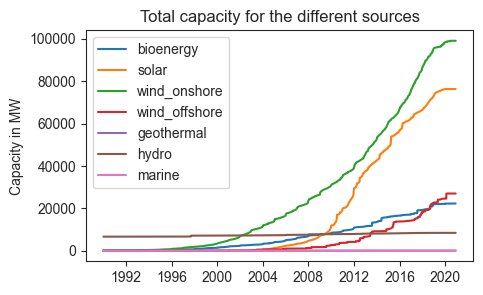

In [7]:
# specify the labels for the timeseries lineplot
labels = ["bioenergy", "solar", "wind_onshore", "wind_offshore" , "geothermal", "hydro", "marine"]
# specify the title for the plot
title = "Total capacity for the different sources"
# plot the timeseries lineplot
plot_df_timeseries(energy_uptake, labels, title)

In [8]:
# Defining the Query
sql = """select day, ch_bioenergy_capacity + ch_solar_capacity + ch_wind_onshore_capacity Switzerland,
de_bioenergy_capacity + de_geothermal_capacity +de_solar_capacity +
de_wind_offshore_capacity + de_wind_onshore_capacity Germany,
dk_solar_capacity  + dk_wind_offshore_capacity + dk_wind_onshore_capacity Denmark,
fr_bioenergy_capacity + fr_geothermal_capacity + fr_hydro_capacity
+ fr_marine_capacity + fr_solar_capacity + fr_wind_onshore_capacity France,
gb_ukm_bioenergy_capacity + gb_ukm_hydro_capacity + gb_ukm_marine_capacity
 + gb_ukm_solar_capacity  + gb_ukm_wind_offshore_capacity + gb_ukm_wind_onshore_capacity Great_Britain,
  se_wind_offshore_capacity  Sweden from renewable_capacity_timeseries
  where day >= date('1990-01-01') order by day asc"""

country_usage = presto.execute_db_query(sql) #get the query results as a dataframe
print(country_usage.shape) #print the shape of the dataframe
country_usage['day'] = pd.to_datetime(country_usage['day']) # convert day column to datetime
country_usage.head() #display the dataframe head

(22588, 7)


,day,Switzerland,Germany,Denmark,France,Great_Britain,Sweden
0,1990-01-01,0.0,76.443,27.5,232.525,3281.0,0.0
1,1990-01-01,0.0,76.443,27.5,232.525,3281.0,0.0
2,1990-01-02,0.0,76.443,27.5,232.525,3281.0,0.0
3,1990-01-02,0.0,76.443,27.5,232.525,3281.0,0.0
4,1990-01-03,0.0,76.443,27.5,232.525,3281.0,0.0


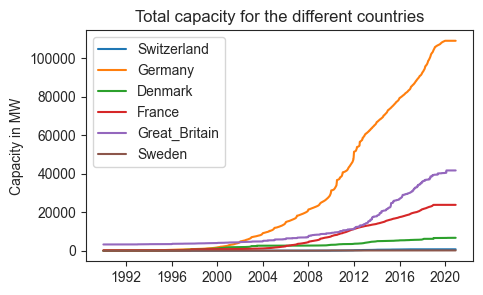

In [9]:
# specify the labels for the timeseries lineplot
labels = ["Switzerland", "Germany", "Denmark", "France", "Great_Britain", "Sweden"]
title = "Total capacity for the different countries"
plot_df_timeseries(country_usage, labels, title)

In [10]:
# Looking at the Shape for Germany table
table = "renewable_power_plants_de"
presto.get_table_shape(table)

(3537490, 23)

In [11]:
# Looking at the Shape for Timeseries table
table = "renewable_capacity_timeseries"
presto.get_table_shape(table)

(88332, 40)

In [12]:
# Defining the Query
query = """select distinct day, de_bioenergy_capacity, de_geothermal_capacity, de_solar_capacity,
           de_wind_offshore_capacity, de_wind_onshore_capacity
           from renewable_capacity_timeseries where day >= date('1990-01-01')
           order by day asc"""

germany_ts = presto.execute_db_query(query)
print(germany_ts.shape)
germany_ts['day'] = pd.to_datetime(germany_ts['day'])
germany_ts.head()

(11294, 6)


,day,de_bioenergy_capacity,de_geothermal_capacity,de_solar_capacity,de_wind_offshore_capacity,de_wind_onshore_capacity
0,1990-01-01,74.418,0.0,0.224,0.0,1.801
1,1990-01-02,74.418,0.0,0.224,0.0,1.801
2,1990-01-03,74.418,0.0,0.224,0.0,1.801
3,1990-01-04,74.778,0.0,0.224,0.0,1.801
4,1990-01-05,74.778,0.0,0.224,0.0,1.801


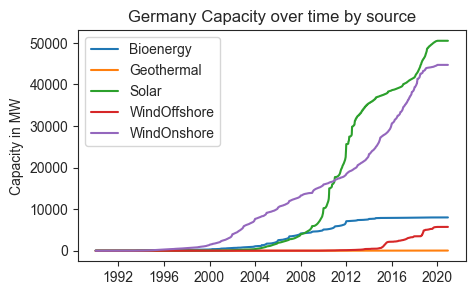

In [13]:
# specify the labels for the timeseries lineplot
labels =['Bioenergy', 'Geothermal', 'Solar', 'WindOffshore', 'WindOnshore']
title = "Germany Capacity over time by source"
plot_df_timeseries(germany_ts,labels, title)

In [14]:
# Defining the Query
query = """select distinct day ds, de_bioenergy_capacity, de_geothermal_capacity, de_solar_capacity,
           de_wind_offshore_capacity, de_wind_onshore_capacity, 
           de_bioenergy_capacity + de_geothermal_capacity + de_solar_capacity +
           de_wind_offshore_capacity + de_wind_onshore_capacity y
           from renewable_capacity_timeseries where day >= date('1980-01-01')
           order by day asc"""

# Qerying based on the defined query
germany_ts = presto.execute_db_query(query) 
germany_ts['ds'] = pd.to_datetime(germany_ts['ds'])
# Split the data into training and testing
train_size = 0.83 # choose a split size 
cut = len(germany_ts) * train_size # get the train size
germany_ts_train = germany_ts.loc[:cut] # define the train dataset
germany_ts_test = germany_ts.loc[cut:] # define the test dataset

# print the shapes of test and train 
print('Train size:\t', len(germany_ts_train))
print('Test size:\t', len(germany_ts_test))

Train size:	 12407
Test size:	 2540


In [15]:
# Instantiate the Prophet model
prophet_model = Prophet(interval_width=0.95)

# Fit the model
prophet_model.fit(germany_ts_train)

# Make predictions on the test set
prophet_pred = prophet_model.predict(germany_ts_test[['ds']])

# Calculate MAPE (Mean Absolute Percentage Error) and print ot
mape = round(mean_absolute_percentage_error(germany_ts_test['y'], prophet_pred['yhat']), 2)
print(f"Mape = {mape}")

19:15:03 - cmdstanpy - INFO - Chain [1] start processing
19:15:07 - cmdstanpy - INFO - Chain [1] done processing


Mape = 0.02


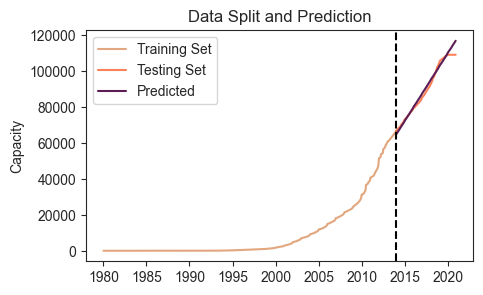

In [16]:
# Get the date where the train set ends
cut_date = germany_ts.iloc[len(germany_ts_train)][0]

# Plot the train, trst actual vs. the test predicted data
plt.figure(figsize=(5,3))

plt.plot(germany_ts_train['ds'], germany_ts_train['y'], label='Training Set', color='#e2a77e')
plt.plot(germany_ts_test['ds'], germany_ts_test['y'], label='Testing Set', color='#fb815a')
plt.plot(germany_ts_test['ds'], prophet_pred['yhat'], label='Predicted', color='#5c1d54')

plt.axvline(cut_date, color='black', ls='--')
plt.title('Data Split and Prediction')
plt.xlabel('')
plt.ylabel('Capacity')
plt.legend()

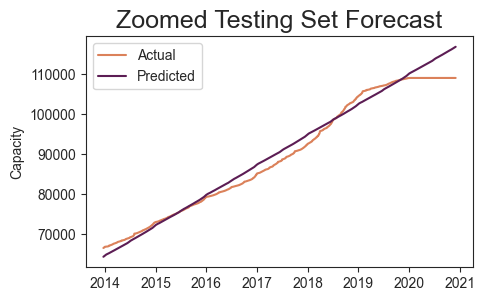

In [17]:
# Plot the actual vs. the predicted data; zoomed in
plt.figure(figsize=(5,3))
plt.plot(germany_ts_test['ds'], germany_ts_test['y'], label='Actual', color='#db815a')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted', color='#5c1d54')
plt.title('Zoomed Testing Set Forecast', size=18)
plt.xlabel('')
plt.ylabel('Capacity')
plt.legend()

In [18]:
# Setup a new Prophet model, because now we want to train it with the whole data (and not only the test set)
prophet_model2 = Prophet(interval_width=0.95)

# Fit the model
prophet_model2.fit(germany_ts)

# Generate the future datapoints on which we are making predictions
future = prophet_model2.make_future_dataframe(periods=365, freq='D')

future

19:15:10 - cmdstanpy - INFO - Chain [1] start processing
19:15:15 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,1980-01-01
1,1980-01-02
2,1980-01-03
3,1980-01-04
4,1980-01-05
...,...
15307,2021-11-28
15308,2021-11-29
15309,2021-11-30
15310,2021-12-01


In [19]:
# Make predictions
prophet_pred2 = prophet_model2.predict(future)
prophet_pred2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-01-01,27.061526,-1434.637814,1939.358476,27.061526,27.061526,262.900022,262.900022,262.900022,-3.794779,-3.794779,-3.794779,266.694801,266.694801,266.694801,0.0,0.0,0.0,289.961548
1,1980-01-02,27.087420,-1448.684689,1985.284021,27.087420,27.087420,269.923578,269.923578,269.923578,-1.191150,-1.191150,-1.191150,271.114729,271.114729,271.114729,0.0,0.0,0.0,297.010998
2,1980-01-03,27.113313,-1522.834052,2042.653250,27.113313,27.113313,278.997391,278.997391,278.997391,4.468874,4.468874,4.468874,274.528517,274.528517,274.528517,0.0,0.0,0.0,306.110704
3,1980-01-04,27.139207,-1217.271970,2083.818840,27.139207,27.139207,284.066627,284.066627,284.066627,7.102063,7.102063,7.102063,276.964564,276.964564,276.964564,0.0,0.0,0.0,311.205833
4,1980-01-05,27.165100,-1321.681958,2015.459108,27.165100,27.165100,280.614358,280.614358,280.614358,2.152912,2.152912,2.152912,278.461445,278.461445,278.461445,0.0,0.0,0.0,307.779458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,2021-11-28,120706.880973,118716.261980,122529.067974,119788.550736,121747.170868,-140.267548,-140.267548,-140.267548,-4.113769,-4.113769,-4.113769,-136.153779,-136.153779,-136.153779,0.0,0.0,0.0,120566.613425
15308,2021-11-29,120725.767833,118739.121198,122722.540871,119804.884819,121769.449157,-133.982162,-133.982162,-133.982162,-4.624150,-4.624150,-4.624150,-129.358012,-129.358012,-129.358012,0.0,0.0,0.0,120591.785670
15309,2021-11-30,120744.654693,118765.881614,122609.718743,119821.088577,121791.727446,-125.620627,-125.620627,-125.620627,-3.794779,-3.794779,-3.794779,-121.825847,-121.825847,-121.825847,0.0,0.0,0.0,120619.034066
15310,2021-12-01,120763.541552,118734.986054,122585.540823,119835.318442,121814.005735,-114.736530,-114.736530,-114.736530,-1.191150,-1.191150,-1.191150,-113.545380,-113.545380,-113.545380,0.0,0.0,0.0,120648.805022


<Figure size 500x300 with 0 Axes>

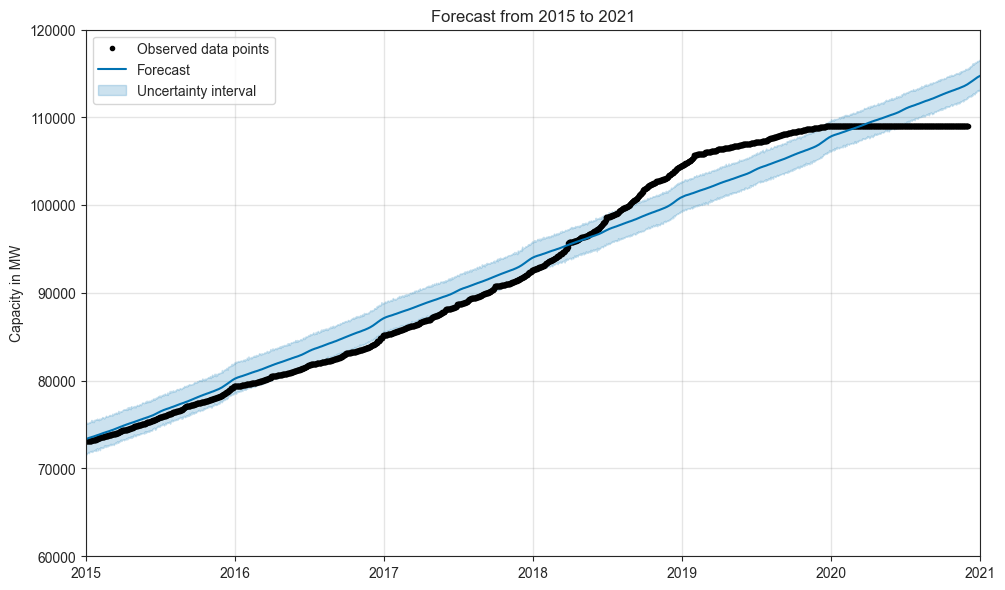

In [20]:
# Plot the forecast
plt.figure(figsize=(5,3))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2015-01-01', '2021-01-01']))
ax.set_ylim([60000, 120000])
plt.legend()
plt.xlabel('')
plt.ylabel('Capacity in MW')
plt.title('Forecast from 2015 to 2021')
plt.show()

## LOOKING AT THE ELECTRICITY CAPACITY BY TECHNOLOGIES

In [21]:
# Defining the Query
query = """select technology, sum(electrical_capacity) electrical_capacity_sum
       from renewable_power_plants_de group by technology
order by electrical_capacity_sum desc"""
df2 = presto.execute_db_query(query)
print(df2.shape)
df2.head()

(8, 2)


,technology,electrical_capacity_sum
0,Photovoltaics,87733.585684
1,Onshore,84503.538594
2,Biomass and biogas,15513.146062
3,Offshore,6965.308000
4,Run-of-river,3086.429510


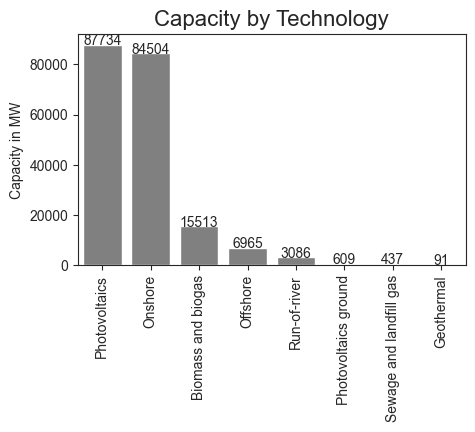

In [22]:
# Plot the summed up capacity by technology
plt.figure(figsize=(5, 3))
sns.barplot(data = df2, x = 'technology', y = 'electrical_capacity_sum',color='grey')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Capacity in MW')
plt.title('Capacity by Technology', size = 16)

# Display values on top of the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01, f'{int(round(height))}', ha='center')

In [23]:
## LOOKING AT THE MEAN OVER THIS PERIOD
# Defining the Query
query = """select distinct technology, avg(electrical_capacity) electrical_capacity_mean
       from renewable_power_plants_de group by technology
order by electrical_capacity_mean desc"""
df3 = presto.execute_db_query(query)
print(df3.shape)
df3.head()

(8, 2)


,technology,electrical_capacity_mean
0,Offshore,4.744760
1,Geothermal,4.144909
2,Onshore,1.960912
3,Photovoltaics ground,1.740282
4,Biomass and biogas,0.557105


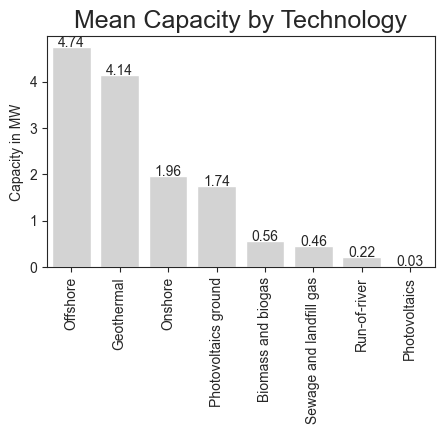

In [24]:
# Plot the mean of capacity by technology
plt.figure(figsize=(5, 3))
sns.barplot(data = df3, x = 'technology', y = 'electrical_capacity_mean',color='lightgrey')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Capacity in MW')
plt.title('Mean Capacity by Technology', size = 18)

# Display values on top of the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01, f'{(round(height, 2))}', ha='center')

In [25]:
## LOOKING AT THE SUM OVER THIS PERIOD
# Defining the Query
query = """select federal_state, sum(electrical_capacity) electrical_capacity_sum
       from renewable_power_plants_de group by federal_state
order by 2 desc limit 10"""
df4 = presto.execute_db_query(query)
print(df4.shape)
df4.head(10)

(10, 2)


,federal_state,electrical_capacity_sum
0,Brandenburg,44178.913070
1,Niedersachsen,29061.773698
2,Nordrhein-Westfalen,21929.771199
3,Saarland,17087.333555
4,Baden-Württemberg,16222.551868
5,Sachsen-Anhalt,13877.293416
6,Rheinland-Pfalz,11249.949434
7,Mecklenburg-Vorpommern,9282.710350
8,Bayern,6901.003386
9,Sachsen,6724.891634


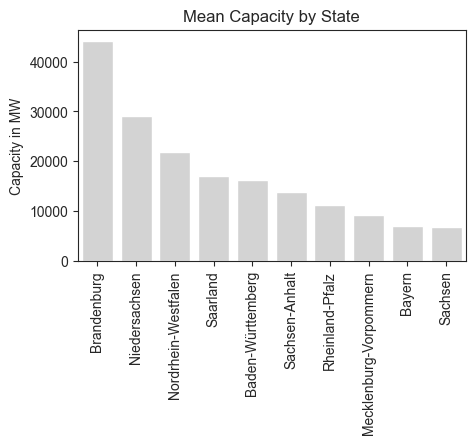

In [26]:
# Plot the mean of capacity by technology

plt.figure(figsize=(5, 3))
sns.barplot(data = df4, x = 'federal_state', y = 'electrical_capacity_sum',color='lightgrey')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Capacity in MW')
plt.title('Mean Capacity by State')

# Display values on top of the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()

# NUTS LEVEL 1 (State)

In [27]:
# Defining the Query
sql = """ select trim(nuts_1_region) nuts_1_region, sum(electrical_capacity) electrical_capacity
 from renewable_power_plants_de
where federal_state in (select federal_state from renewable_power_plants_de )
and lon is not null and lat is not null
group by trim(nuts_1_region) order by 2 desc"""
df_region = presto.execute_db_query(sql)
print(df_region.shape)
df_region.head(10)

(16, 2)


,nuts_1_region,electrical_capacity
0,DE2,33225.367218
1,DE9,28711.755350
2,DEA,21942.029321
3,DE4,17869.769540
4,DE1,16636.551744
5,DEF,15601.052380
6,DEE,13824.395454
7,DEB,11253.277514
8,DE8,9755.525162
9,DE7,8168.392748


In [28]:
# Loading the shape file
# This is essential in ploting a map
fp = 'DEU_adm/DEU_adm1.shp'
map_df = gpd.read_file(fp)
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,86,DEU,Germany,1,Baden-Württemberg,Land,State,None,None,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,86,DEU,Germany,2,Bayern,Land,State,None,Bavaria,"POLYGON ((10.13386 50.55000, 10.13980 50.54252..."
2,86,DEU,Germany,3,Berlin,Land,State,None,None,"POLYGON ((13.17789 52.39032, 13.16575 52.39050..."
3,86,DEU,Germany,4,Brandenburg,Land,State,None,None,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,86,DEU,Germany,5,Bremen,Land,State,None,None,"MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2..."


In [29]:
# Loading the dataset that links Nuts region codes and Names
nuts_region_names = pd.read_csv('NUTS-Germany.csv')
print(nuts_region_names.shape)
nuts_region_names.head()

(459, 6)


,Code 2021,Country,NUTS level 1,NUTS level 2,NUTS level 3,NUTS level
0,DE,Deutschland,NaN,NaN,NaN,0
1,DE1,NaN,Baden-Württemberg,NaN,NaN,1
2,DE11,NaN,NaN,Stuttgart,NaN,2
3,DE111,NaN,NaN,NaN,"Stuttgart, Stadtkreis",3
4,DE112,NaN,NaN,NaN,Böblingen,3


In [30]:
# Replacing the Nuts region codes with names
df_region_names = df_region.merge(nuts_region_names[nuts_region_names['NUTS level']==1], left_on='nuts_1_region', right_on='Code 2021', how='left')
df_region_names = df_region_names[['NUTS level 1', 'electrical_capacity']]
df_region_names.head(10)

,NUTS level 1,electrical_capacity
0,Bayern,33225.367218
1,Niedersachsen,28711.755350
2,Nordrhein-Westfalen,21942.029321
3,Brandenburg,17869.769540
4,Baden-Württemberg,16636.551744
5,Schleswig-Holstein,15601.052380
6,Sachsen-Anhalt,13824.395454
7,Rheinland-Pfalz,11253.277514
8,Mecklenburg-Vorpommern,9755.525162
9,Hessen,8168.392748


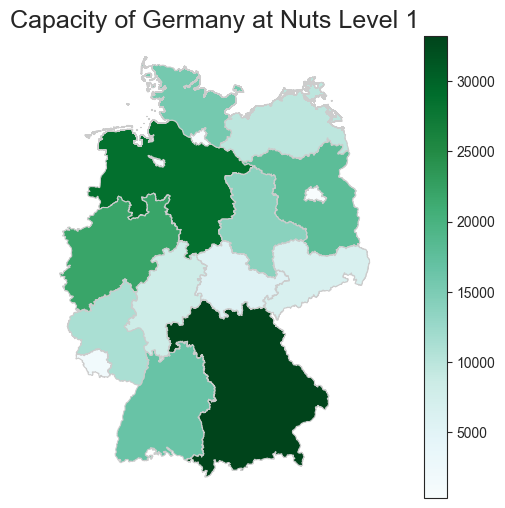

In [31]:
# Plotting the Germany map showing capacity by State (Nuts Region 1)
merged = map_df.set_index('NAME_1').join(df_region_names.set_index('NUTS level 1'))
vmin, vmax = df_region['electrical_capacity'].min(), df_region['electrical_capacity'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='electrical_capacity', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Capacity of Germany at Nuts Level 1', fontsize=18)
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

# NUTS LEVEL 2 (City)

In [32]:
# Defining the Query
sql = """ select trim(nuts_2_region) nuts_2_region, sum(electrical_capacity) electrical_capacity
 from renewable_power_plants_de
where federal_state in (select federal_state from renewable_power_plants_de )
and lon is not null and lat is not null
group by trim(nuts_2_region) order by 2 desc"""
df_region = presto.execute_db_query(sql)
print(df_region.shape)
df_region.head(10)

(38, 2)


,nuts_2_region,electrical_capacity
0,DE40,17869.769540
1,DEF0,15601.052380
2,DE94,14122.011076
3,DEE0,13824.395454
4,DE80,9755.525162
5,DE93,7019.675678
6,DE21,6653.850232
7,DEA3,6197.243275
8,DE22,6172.532076
9,DE11,6158.433044


In [33]:
# Loading the shape file with City boundaries
fp = 'DEU_adm/DEU_adm2.shp'
map_df = gpd.read_file(fp)
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,86,DEU,Germany,1,Baden-Württemberg,1,Freiburg,Regierungsbezirk,Administrative Region,None,Friburgo|Fribourg,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,86,DEU,Germany,1,Baden-Württemberg,2,Karlsruhe,Regierungsbezirk,Administrative Region,None,None,"POLYGON ((9.45798 49.64889, 9.46381 49.64518, ..."
2,86,DEU,Germany,1,Baden-Württemberg,3,Stuttgart,Regierungsbezirk,Administrative Region,None,Estugarda,"POLYGON ((9.65046 49.77634, 9.65097 49.76515, ..."
3,86,DEU,Germany,1,Baden-Württemberg,4,Tübingen,Regierungsbezirk,Administrative Region,None,Tubinga,"POLYGON ((9.95117 48.63168, 9.95123 48.62800, ..."
4,86,DEU,Germany,2,Bayern,5,Mittelfranken,Regierungsbezirk,Administrative Region,None,Franconia Central|Middle Franconia|Média Franc...,"POLYGON ((10.74197 49.77239, 10.75361 49.76886..."


In [34]:
df_region_names = df_region.merge(nuts_region_names[nuts_region_names['NUTS level']==2], left_on='nuts_2_region', right_on='Code 2021', how='left')
df_region_names = df_region_names[['NUTS level 2', 'electrical_capacity']].drop_duplicates()
df_region_names.head( 10)

,NUTS level 2,electrical_capacity
0,Brandenburg,17869.769540
1,Schleswig-Holstein,15601.052380
2,Weser-Ems,14122.011076
3,Sachsen-Anhalt,13824.395454
4,Mecklenburg-Vorpommern,9755.525162
5,Lüneburg,7019.675678
6,Oberbayern,6653.850232
7,Münster,6197.243275
8,Niederbayern,6172.532076
9,Stuttgart,6158.433044


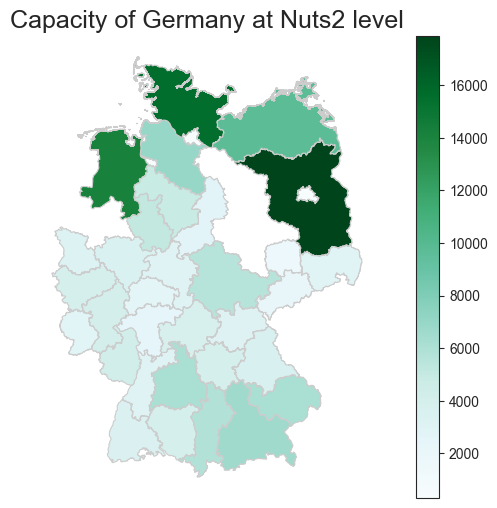

In [35]:
merged = map_df.set_index('NAME_2').join(df_region_names.set_index('NUTS level 2'))
vmin, vmax = df_region['electrical_capacity'].min(), df_region['electrical_capacity'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='electrical_capacity', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Capacity of Germany at Nuts2 level', fontsize=18)
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

# NUTS LEVEL 3 (Municipality)

In [36]:

nuts_level = 3
sql = f""" select trim(nuts_3_region) nuts_3_region, sum(electrical_capacity) electrical_capacity
    from renewable_power_plants_de
    where federal_state in (select federal_state from renewable_power_plants_de )
    and lon is not null and lat is not null
    group by trim(nuts_3_region) order by 2 desc"""
df_region = presto.execute_db_query(sql)
print(df_region.shape)
df_region.head(10)

(401, 2)


,nuts_3_region,electrical_capacity
0,DEF07,4342.831794
1,DEF05,3852.047702
2,DE949,3371.248996
3,DE40I,2880.311534
4,DEF0C,2845.580960
5,DEA47,2223.172864
6,DE80K,2131.852310
7,DE80N,2105.927442
8,DE80J,2071.056200
9,DE947,2011.225606


In [37]:
# Loading the shape file with City boundaries
fp = f'DEU_adm/DEU_adm3.shp'
map_df = gpd.read_file(fp)
# map_df['NAME_3']=[i.replace('\r\n', '') for i in map_df['NAME_3']]
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry
0,86,DEU,Germany,1,Baden-Württemberg,1,Freiburg,1,Breisgau-Hochschwarzwald,Landkreise,Rural district,None,None,"POLYGON ((7.55564 47.87053, 7.55578 47.87120, ..."
1,86,DEU,Germany,1,Baden-Württemberg,1,Freiburg,2,Emmendingen,Landkreise,Rural district,None,None,"POLYGON ((7.57809 48.11961, 7.57786 48.12139, ..."
2,86,DEU,Germany,1,Baden-Württemberg,1,Freiburg,3,Freiburg,None,None,None,None,"POLYGON ((7.82635 48.07057, 7.83203 48.06703, ..."
3,86,DEU,Germany,1,Baden-Württemberg,1,Freiburg,4,Konstanz,Landkreise,Rural district,None,Constance,"MULTIPOLYGON (((8.85385 47.68377, 8.85416 47.6..."
4,86,DEU,Germany,1,Baden-Württemberg,1,Freiburg,5,Lörrach \r\nLörrach \r\n,Landkreise,Rural district,None,Lörrach,"POLYGON ((7.63238 47.56242, 7.63560 47.56353, ..."


In [38]:
# Replace NUTS codes with names
df_region_names = df_region.merge(nuts_region_names[nuts_region_names['NUTS level']==3], left_on=f'nuts_{nuts_level}_region', right_on='Code 2021', how='left')
df_region_names = df_region_names[[f'NUTS level 3', 'electrical_capacity']].drop_duplicates()
df_region_names.head(10)

,NUTS level 3,electrical_capacity
0,Nordfriesland,4342.831794
1,Dithmarschen,3852.047702
2,Emsland,3371.248996
3,Uckermark,2880.311534
4,Schleswig-Flensburg,2845.580960
5,Paderborn,2223.172864
6,Landkreis Rostock,2131.852310
7,Vorpommern-Greifswald,2105.927442
8,Mecklenburgische Seenplatte,2071.056200
9,Aurich,2011.225606


In [39]:
merged = map_df.set_index(f'NAME_{nuts_level}').join(df_region_names.set_index(f'NUTS level {nuts_level}'))
vmin, vmax = merged['electrical_capacity'].min(), merged['electrical_capacity'].max()


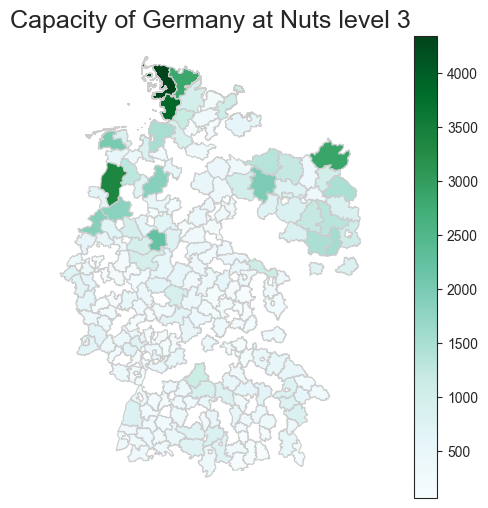

In [40]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='electrical_capacity', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title(f'Capacity of Germany at Nuts level 3', fontsize=18)
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

(401, 2)


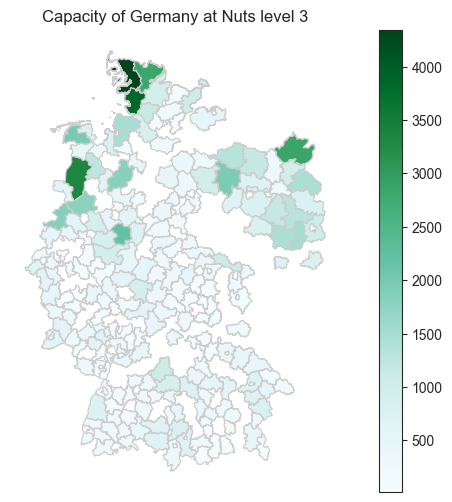

In [41]:
def plot_nuts_map(nuts_level=1):
    sql = f""" select trim(nuts_{nuts_level}_region) nuts_{nuts_level}_region, sum(electrical_capacity) electrical_capacity
    from renewable_power_plants_de
    where federal_state in (select federal_state from renewable_power_plants_de )
    and lon is not null and lat is not null
    group by trim(nuts_{nuts_level}_region) order by 2 desc"""
    df_region = presto.execute_db_query(sql)
    print(df_region.shape)
    df_region.head(10)
    fp = f'DEU_adm/DEU_adm{nuts_level}.shp'
    map_df = gpd.read_file(fp)
    df_region_names = df_region.merge(nuts_region_names[nuts_region_names['NUTS level']==nuts_level], left_on=f'nuts_{nuts_level}_region', right_on='Code 2021', how='left')
    df_region_names = df_region_names[[f'NUTS level {nuts_level}', 'electrical_capacity']].drop_duplicates()
    merged = map_df.set_index(f'NAME_{nuts_level}').join(df_region_names.set_index(f'NUTS level {nuts_level}'))
    vmin, vmax = df_region['electrical_capacity'].min(), df_region['electrical_capacity'].max()
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(10, 6))
    merged.plot(column='electrical_capacity', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.axis('off')
    ax.set_title(f'Capacity of Germany at Nuts level {nuts_level}')
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

plot_nuts_map(3)
